In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  train = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/O/*.jpg')
p= len(train)
p

4863

In [ ]:
train = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/R/*.jpg')
Q= len(train)
Q

4477

In [3]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 7473 images belonging to 2 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 1867 images belonging to 2 classes.


In [6]:
# Class Indices
train_dataset.class_indices

{'O': 0, 'R': 1}

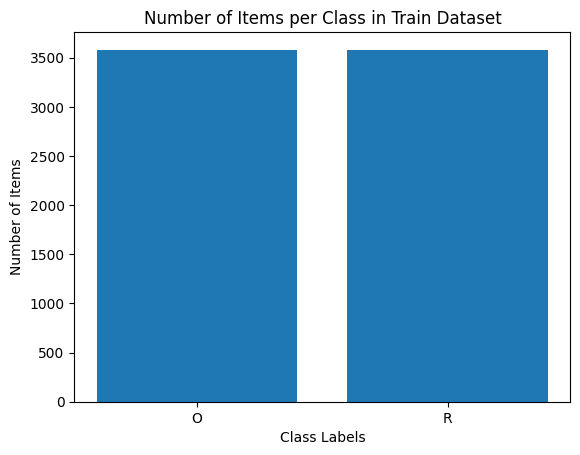

In [7]:
# Count the number of items for each label in the train dataset
train_labels_count = train_dataset.labels.sum(axis=0)

# Get the class labels
class_labels = train_dataset.class_indices.keys()

# Plot the bar graph
plt.bar(class_labels, train_labels_count)
plt.xlabel('Class Labels')
plt.ylabel('Number of Items')
plt.title('Number of Items per Class in Train Dataset')
plt.show()

In [8]:
# Define InceptionV3 base model
base_model = InceptionV3(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')


87910968/87910968 [==============================] - 0s 0us/step


In [9]:
# Freeze layers
for layer in base_model.layers:
    layer.trainable = False


In [10]:
# Summary
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [11]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [12]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization_94 (Ba  (None, 51200)             204800    
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 batch_normalization_95 (Ba  (None, 1024)              4096      
 tchNormalization)                                      

In [13]:
# Model Compile
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

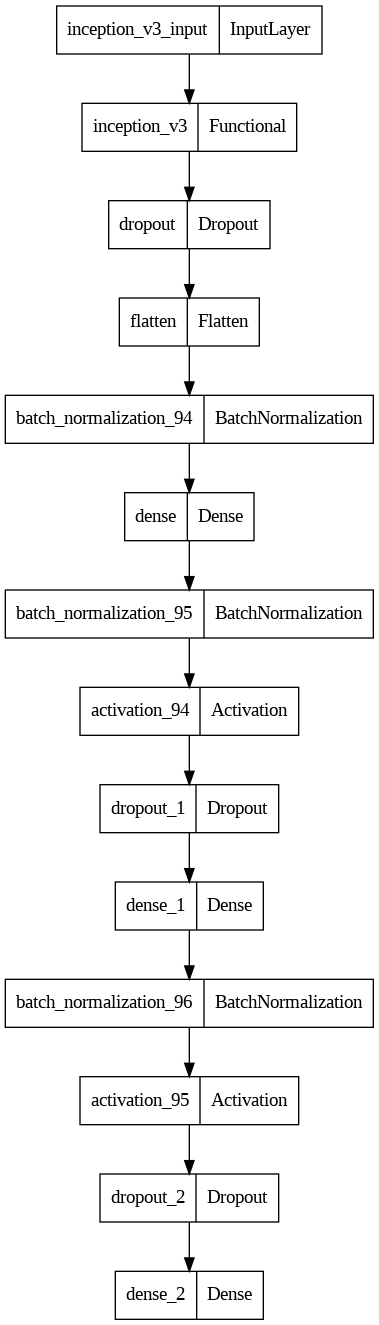

In [14]:
# Defining Callbacks

filepath = './model_inception.h5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]
plot_model(model, to_file='model.png')

In [15]:
# Model Fitting

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 15,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/15
59/59 [==============================] - ETA: 0s - loss: 0.2496 - auc: 0.9660 
Epoch 1: val_auc improved from -inf to 0.92706, saving model to ./model_inception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 1242s 21s/step - loss: 0.2496 - auc: 0.9660 - val_loss: 0.6002 - val_auc: 0.9271
Epoch 2/15
59/59 [==============================] - ETA: 0s - loss: 0.1539 - auc: 0.9847
Epoch 2: val_auc improved from 0.92706 to 0.94477, saving model to ./model_inception.h5
59/59 [==============================] - 134s 2s/step - loss: 0.1539 - auc: 0.9847 - val_loss: 0.4075 - val_auc: 0.9448
Epoch 3/15
59/59 [==============================] - ETA: 0s - loss: 0.1353 - auc: 0.9880
Epoch 3: val_auc did not improve from 0.94477
59/59 [==============================] - 130s 2s/step - loss: 0.1353 - auc: 0.9880 - val_loss: 0.4050 - val_auc: 0.9326
Epoch 4/15
59/59 [==============================] - ETA: 0s - loss: 0.1178 - auc: 0.9909
Epoch 4: val_auc improved from 0.94477 to 0.95455, saving model to ./model_inception.h5
59/59 [==============================] - 135s 2s/step - loss: 0.1178 - auc: 0.9909 - val_loss: 0.3168 - val_auc: 0.9546
Epoch 5/15
59/59 [===========

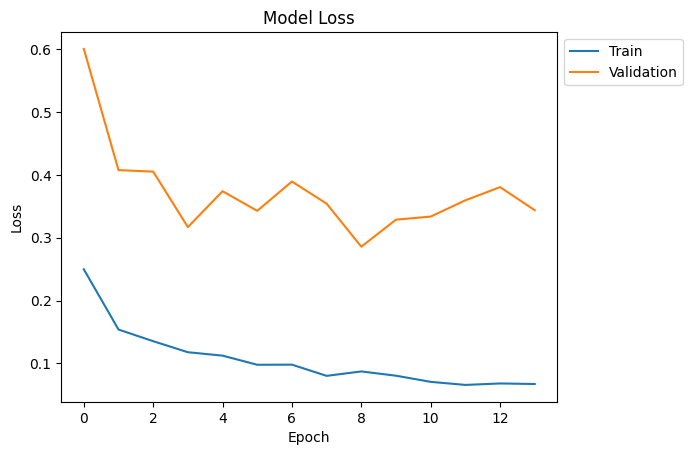

In [16]:
# Summarize the model loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

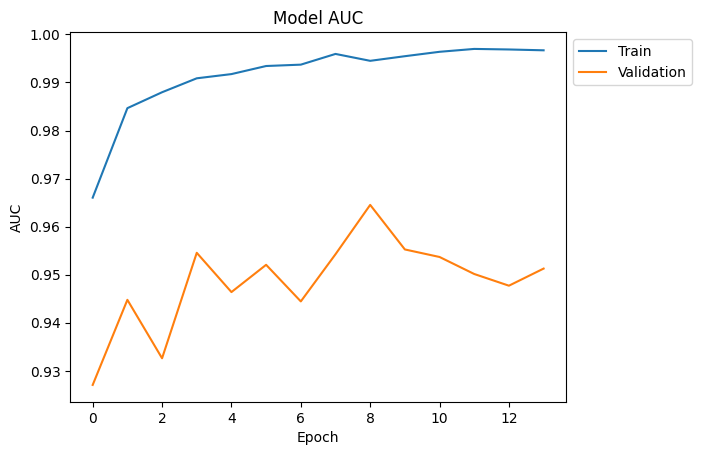

In [17]:
# Summarize models auc
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [18]:
# Test Data
test_data = test_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 1956 images belonging to 2 classes.


In [19]:
# Evaluating Loss and AUC - Test Data
model.evaluate(test_data)

16/16 [==============================] - 238s 16s/step - loss: 0.8082 - auc: 0.9044


[0.8082238435745239, 0.9044418334960938]

1/1 [==============================] - 3s 3s/step
The image belongs to Organic waste category 


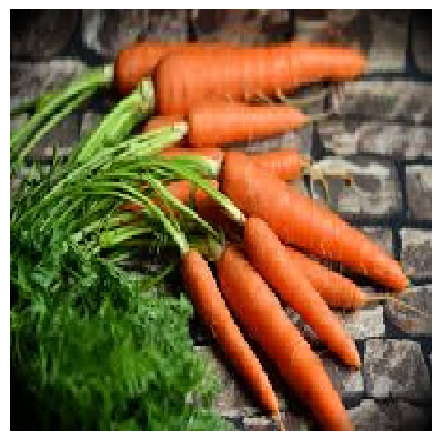

In [20]:
# Test Case:1 - ORGANIC
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/O/O_12701.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 41ms/step
The image belongs to Recycle waste category


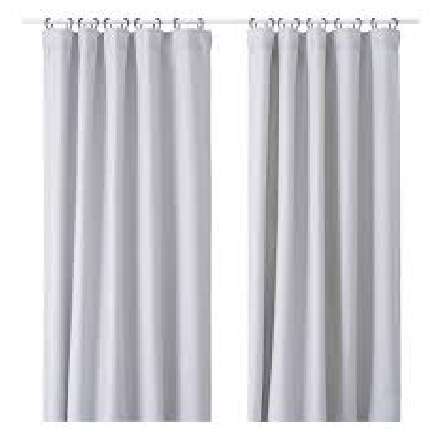

In [21]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/R/R_10004.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [22]:
test_data.reset()  # Reset generator to start of dataset
y_true = test_data.classes
y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)

16/16 [==============================] - 11s 624ms/step


In [23]:
binary_values = (y_pred >= 0.5).astype(int)

In [24]:
reshaped_array = binary_values.reshape(1956)

In [25]:
reshaped_array.shape

(1956,)

In [26]:
y_true.shape

(1956,)

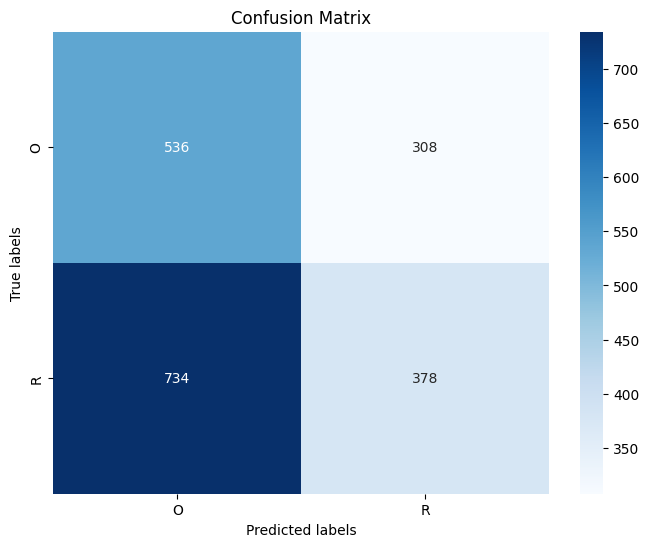

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, reshaped_array)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
binary_values_test = (y_pred >= 0.5).astype(int)

In [29]:
# Calculate Precision, Recall, F1 Score
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, binary_values_test, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.49536941098839415
Recall: 0.467280163599182
F1 Score: 0.457846706381274
